# Book Sentiment Analysis
**This is a notebook that investigates the content of Moby Dick and performs a sentiment analysis.**

The text file for this project was sourced from Project Gutenberg at https://www.gutenberg.org/ebooks/2701. Please see the moby_dick.txt file for license information.
## Imports and Downloads

In [1]:
from random import randint
import re
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from PIL import Image
import wordcloud
%matplotlib inline

Download necessary natural language toolkit data (each statement only needs to be run the first time the notebook is used on a new system)

In [2]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dee\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Load the Text File
Load in the text file, then restrict the data to only the main text.

In [3]:
with open('moby_dick.txt', 'r', encoding='UTF-8') as file:
    book = file.read()
book_contents_end = book.find('  ETYMOLOGY.')
book_epilogue_end = book.find('*** END OF THE PROJECT GUTENBERG EBOOK MOBY-DICK; OR THE WHALE ***')
book = book[book_contents_end:book_epilogue_end]

In [4]:
print(type(book), len(book))

<class 'str'> 1214062


The result is a string with a length of **1.2 million characters** to work with.
## Determine the Number of Chapters
It might seem like a good idea to determine the number of chapters in the book by simply using the count method for the word 'CHAPTER'.

In [5]:
book.count('CHAPTER')

150

However, there are some instances of the word 'CHAPTER' within the text of the book as well. 

Instead, a regular expression(regex) can be used to find only the incidences of the word 'CHAPTER' followed by a space and one or more numbers:

In [6]:
pattern = re.compile('CHAPTER [0-9]+')
chapters = re.findall(pattern, book)
len(chapters)

135

There are **135 chapters** in Moby Dick.
## Identify the Most Frequently Occuring Words
Use a simple regex to extract every substring (word) from the text:

In [7]:
pattern = re.compile('[a-zA-Z]+')
words = re.findall(pattern, book.lower())
print(words[:10])

['etymology', 'supplied', 'by', 'a', 'late', 'consumptive', 'usher', 'to', 'a', 'grammar']


The first 10 words identified from the text.

Next, create a dictionary, with the keys being each unique word in the text and the values being the number of incidences in the text:

In [8]:
word_dict = {}
for word in words:
    if word in word_dict.keys():
        word_dict[word] = word_dict[word] + 1
    else:
        word_dict[word] = 1

Use the dictionary to generate a list of tuples with the first value being the count and the second being the word identified. Then sort this list and display the top 10 most used words:

In [9]:
word_list = [(value, key) for (key, value) in word_dict.items()]
sorted(word_list, reverse=True)[:10]

[(14430, 'the'),
 (6609, 'of'),
 (6430, 'and'),
 (4737, 'a'),
 (4625, 'to'),
 (4173, 'in'),
 (3085, 'that'),
 (2530, 'his'),
 (2522, 'it'),
 (2128, 'i')]

The most commonly used words in the text are mainly articles and pronouns, as is the case for most english language texts. These words tend not to be of any use in analyzing texts. In natural language processing words that contain little semantic value and are not specific to the text are referred to as 'stopwords' and are filtered out.

Start with the nltk english stopwords list then add the stopwords 'ye' and 'thou' which are additional pronouns frequently used in this book. Create a new word list by excluding all words from the stopwords list:

In [10]:
english_stopwords = nltk.corpus.stopwords.words('english')
english_stopwords.append('ye')
english_stopwords.append('thou')

significant_words = []
for count, word in word_list:
    if word not in english_stopwords:
        significant_words.append((count, word))
sorted(significant_words, reverse=True)[:10]

[(1228, 'whale'),
 (921, 'one'),
 (647, 'like'),
 (566, 'upon'),
 (530, 'man'),
 (518, 'ship'),
 (511, 'ahab'),
 (455, 'sea'),
 (450, 'old'),
 (432, 'would')]

These are the 10 most frequently used words in Moby Dick that are identified as semantically significant. 

## Visualize the Most Frequently Used Words

Create a dictionary of the significant words to use for visualization:

In [11]:
significant_words_dict = dict([(word, count) for count, word in significant_words])

Identify only the significant words that only occur more than 250 times in the text, then display those words in a bar graph:

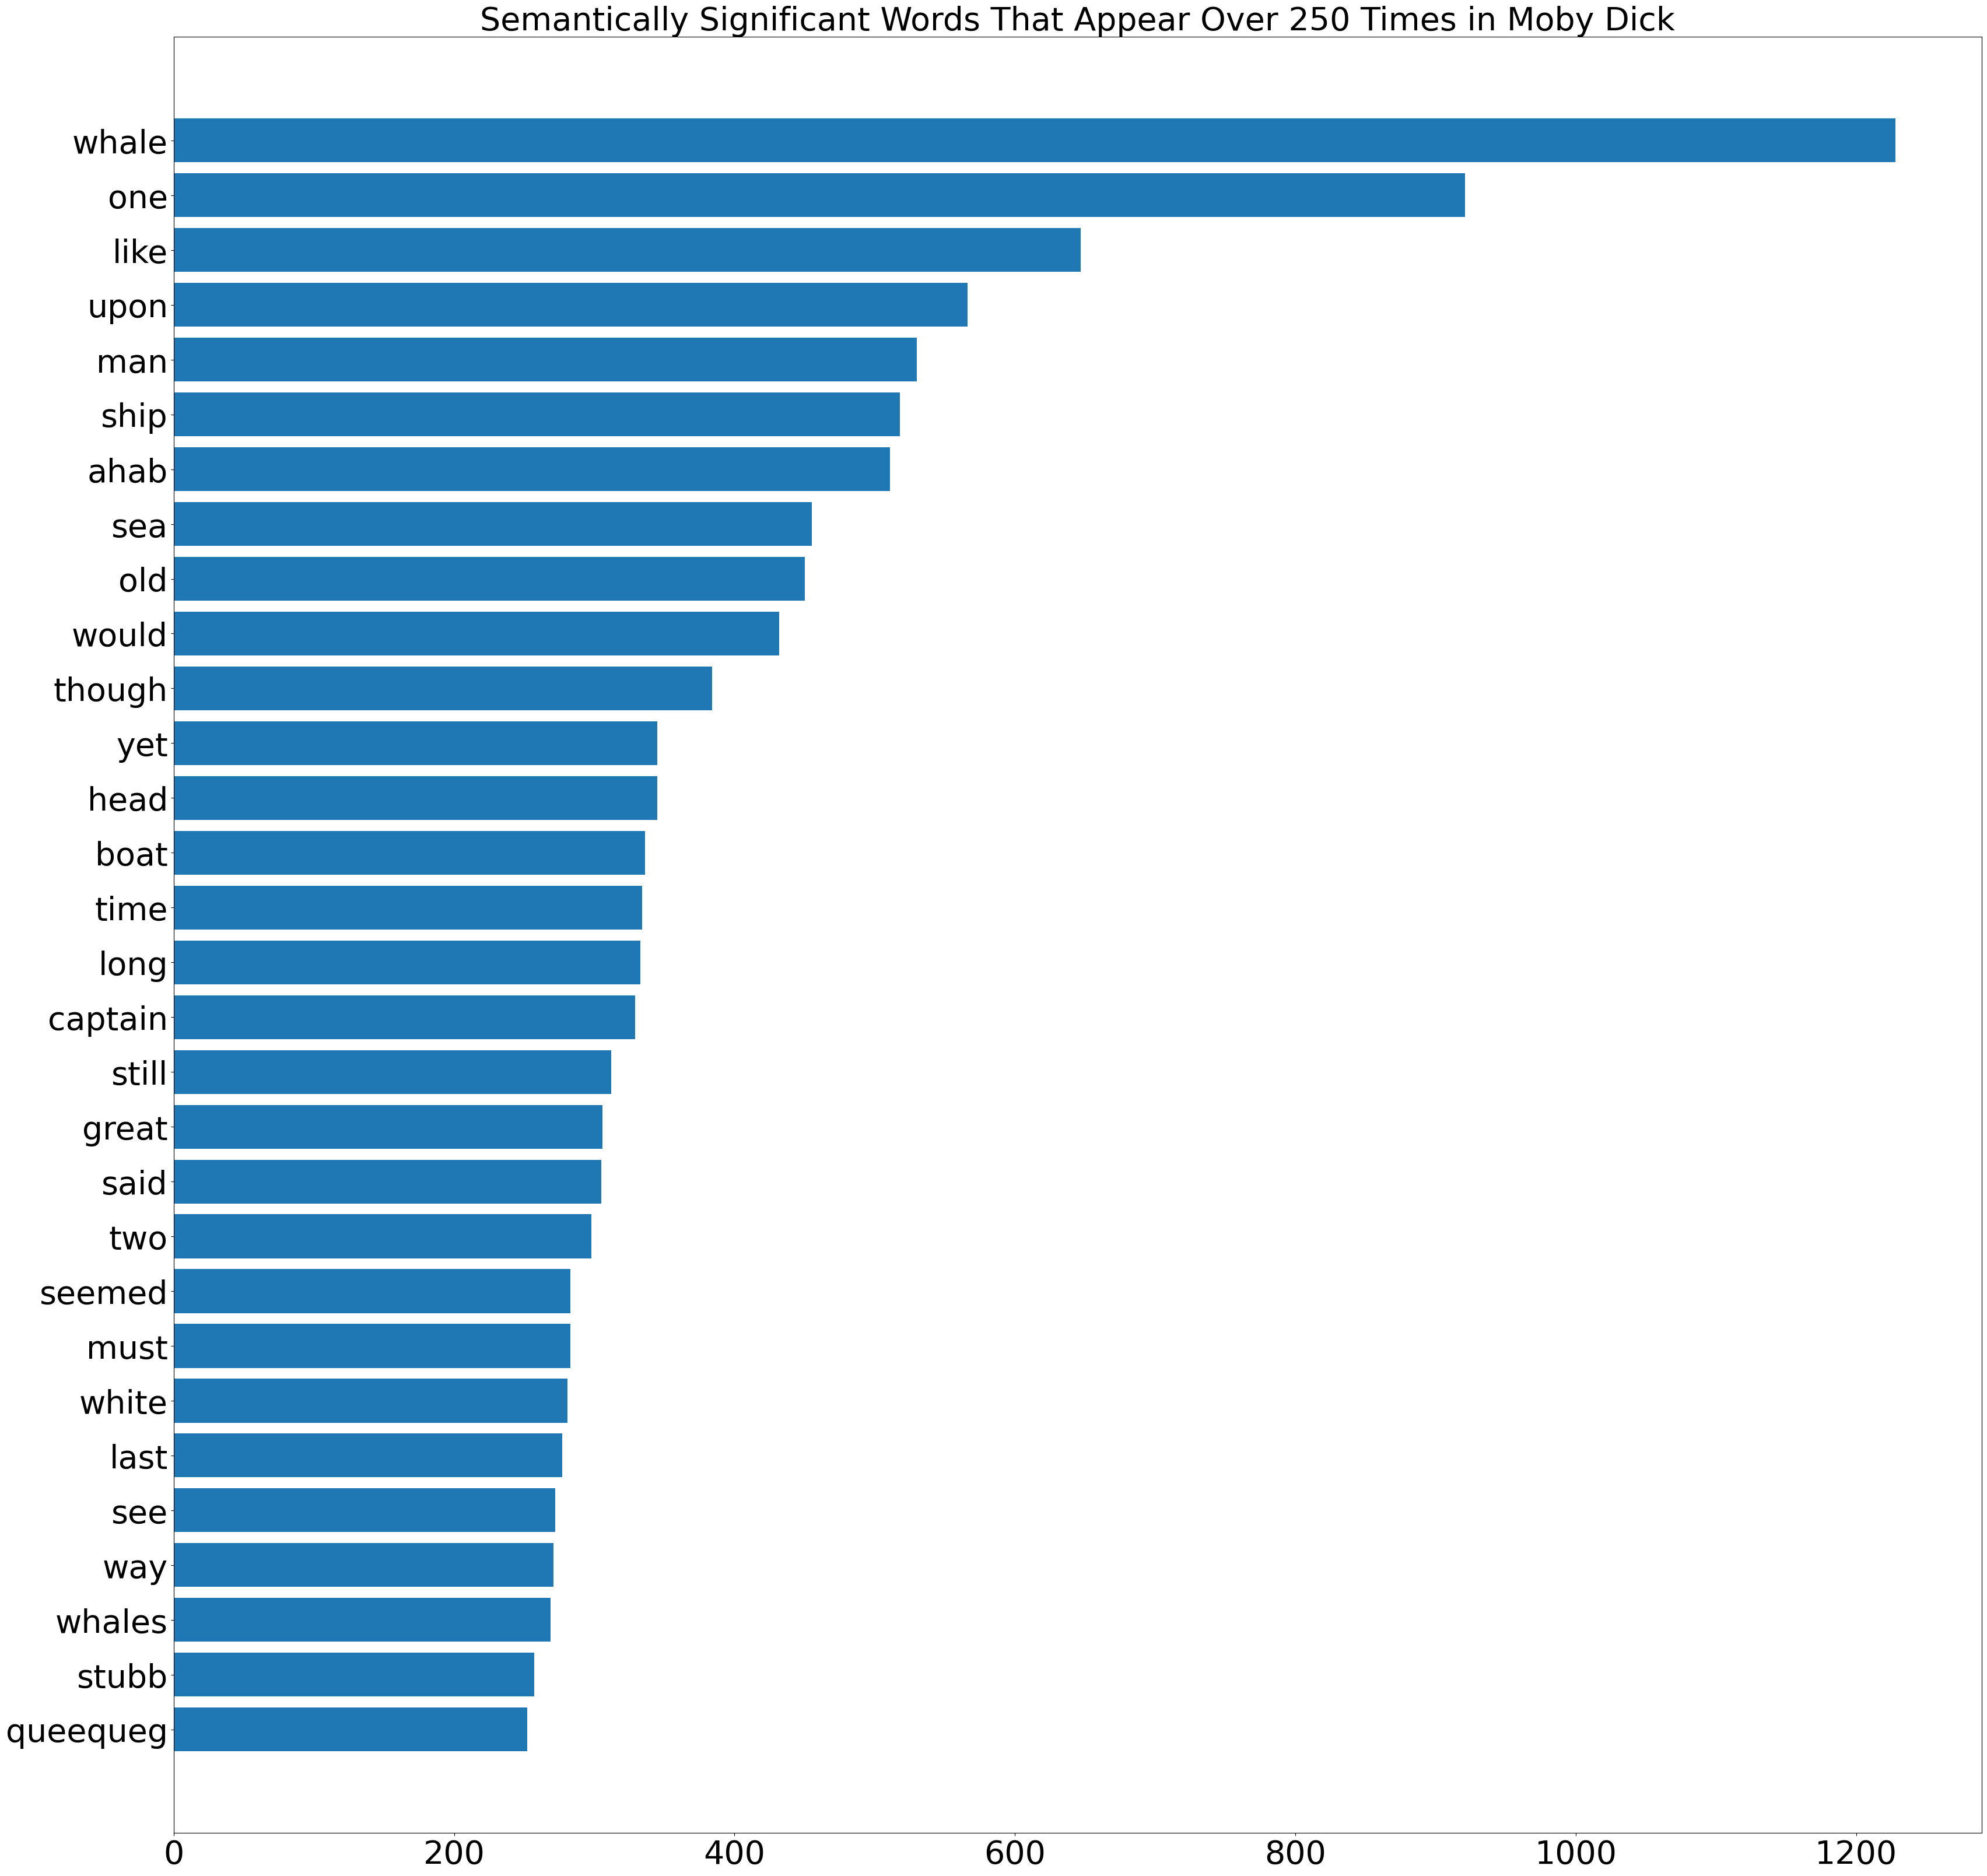

In [12]:
most_significant_dict = dict((key, value) for key, value in significant_words_dict.items() if value >= 250)
most_significant_dict = dict(sorted(most_significant_dict.items(), key=lambda item: item[1]))
plt.figure(figsize=[40,40])
plt.rc('ytick', labelsize=40)
plt.rc('xtick', labelsize=40)
plt.barh(range(len(most_significant_dict)), list(most_significant_dict.values()), tick_label=list(most_significant_dict.keys()))
plt.title('Semantically Significant Words That Appear Over 250 Times in Moby Dick', fontsize=40)
plt.show()

The graph displays the 30 significant words that appear in Moby Dick 250 or more times. It is notable that 'whale' and 'whales' are counted separately in this graph, unlike with a regular expression.

A more visually appealing way to present the most common words is via a word cloud - a visual arrangement of words with font size correlating with frequency. Create a whale-shaped mask, then create a whale-shaped word cloud of the most frequently used words in Moby Dick:

(-0.5, 3999.5, 3174.5, -0.5)

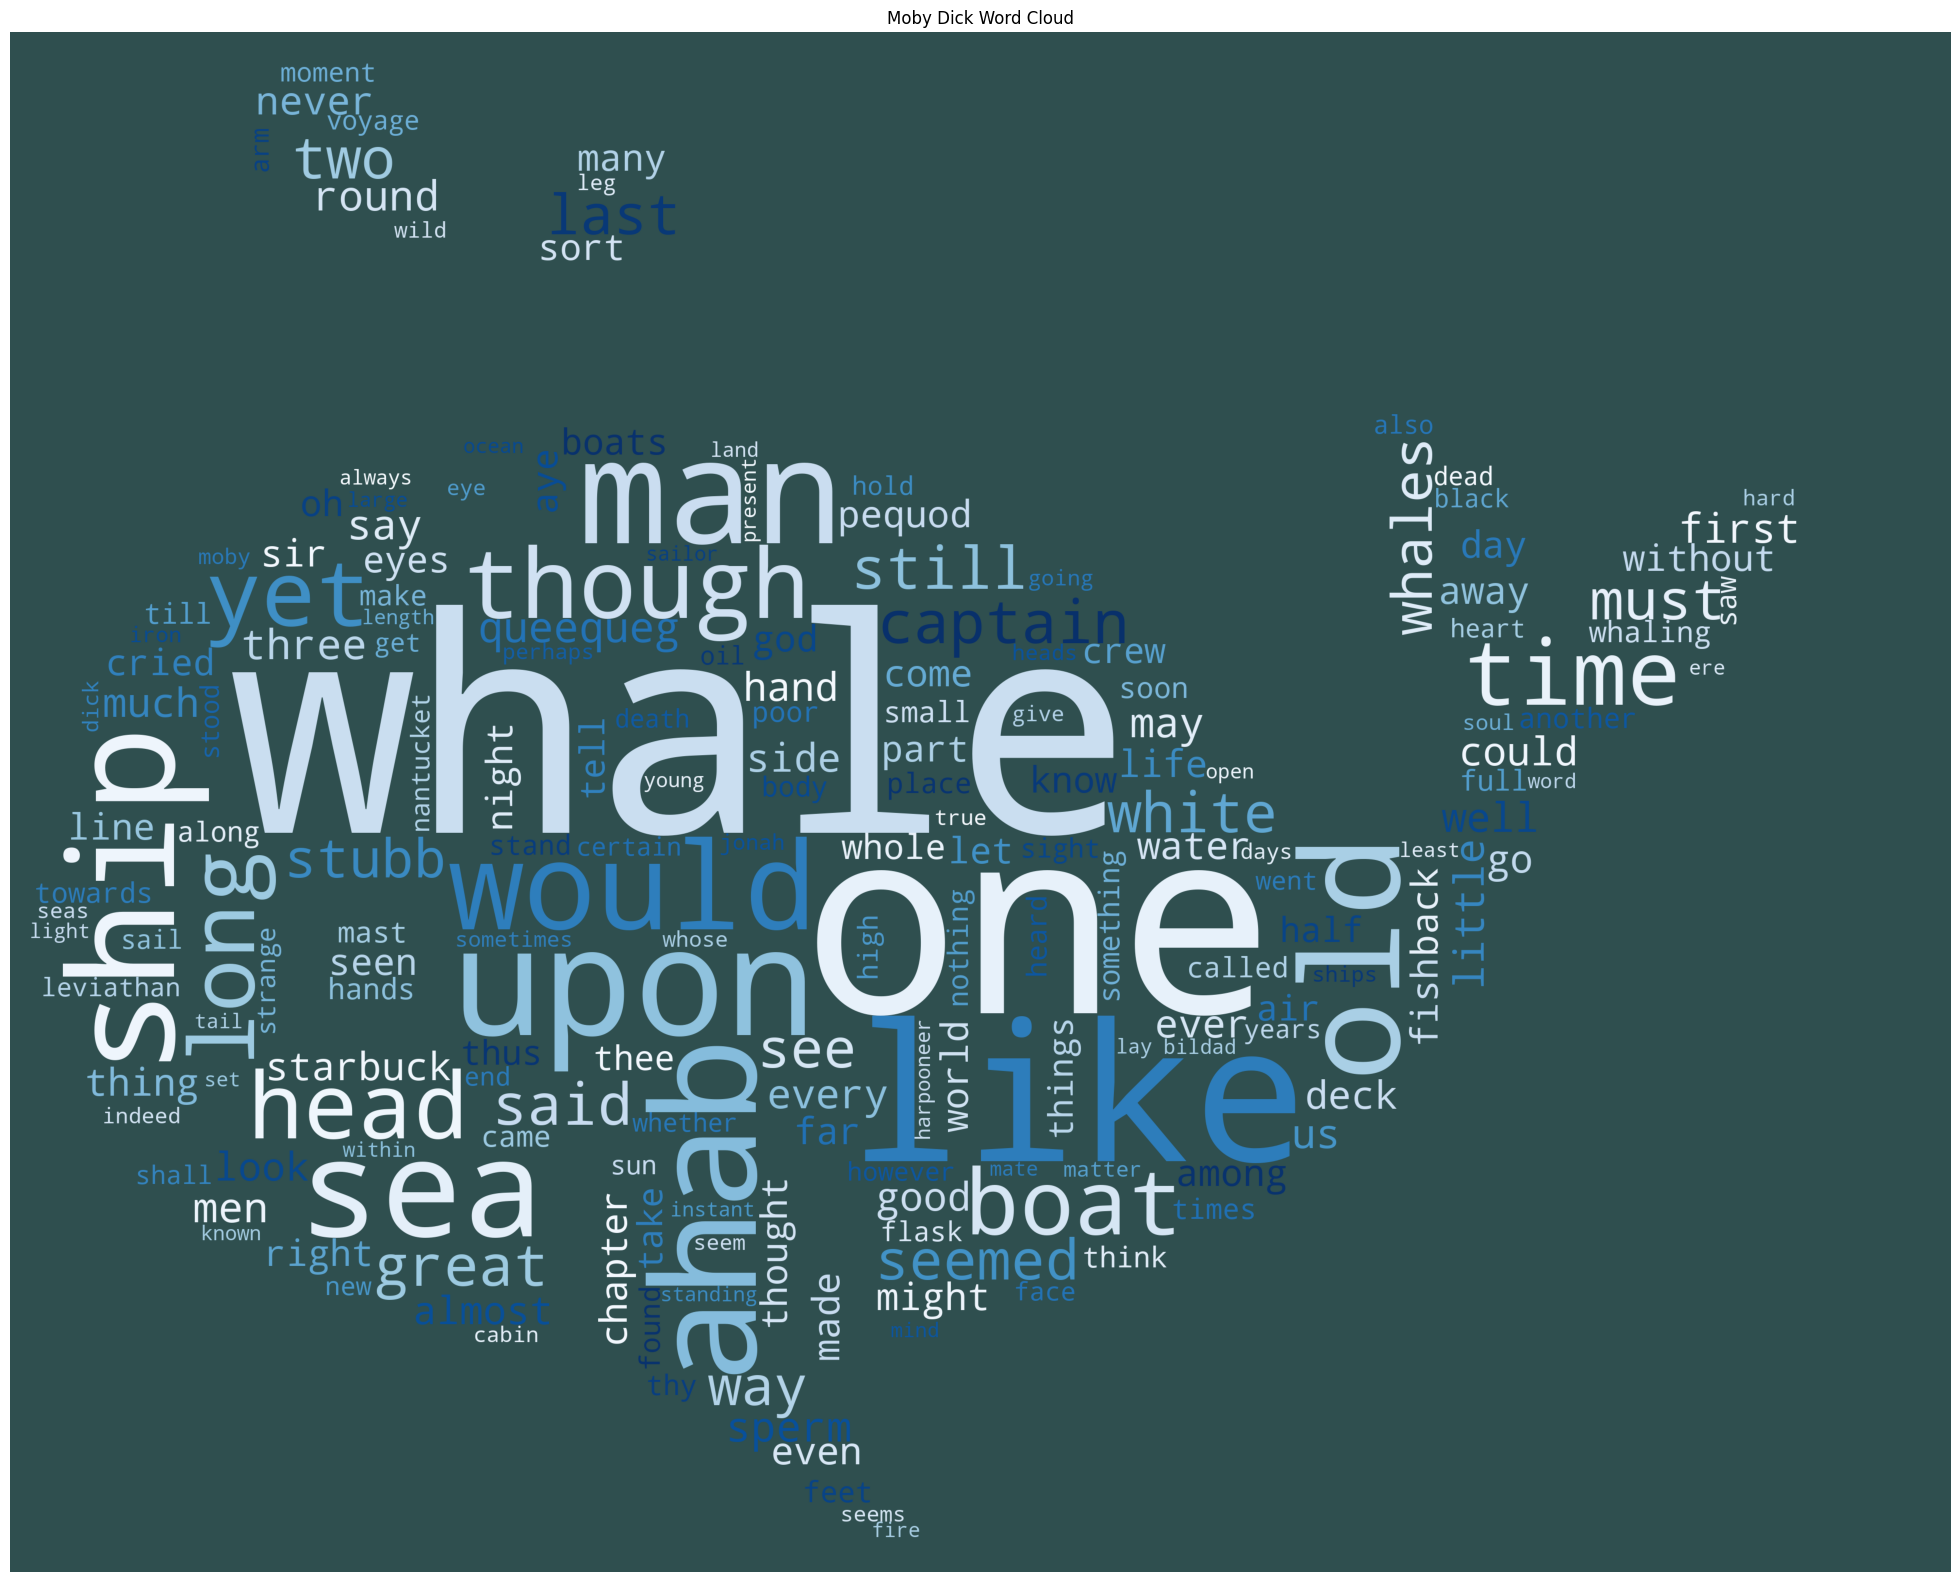

In [13]:
whale_mask= np.array(Image.open('mask.png'))
moby_dick_wordcloud = wordcloud.WordCloud(width=4000,height=3000,background_color='darkslategrey',colormap='Blues', mask=whale_mask).generate_from_frequencies(significant_words_dict)
plt.figure(figsize=[40,20])
plt.imshow(moby_dick_wordcloud)
plt.title('Moby Dick Word Cloud')
plt.axis('off')

## Extract all Sentences in the Book that Include the Word 'Whale'
A complex regular expression can be used to find all the sentences including the word 'whale'.

The regular expression in this case searches for strings using all of the the following conditions:
- Begins with a capital letter
- Followed by 0 or more characters that are not periods, exclamation marks, or question marks
- Then contains either a lowercase or uppercase 'w' followed by 'hale'
- Followed by 0 or 1 incidences of the letter 's'
- Afterward contains 0 or more characters that are not periods, exclamation marks, or question marks
- Ends with a character that is a period, exclamation mark, or question mark

In [14]:
pattern = re.compile('[A-Z][^.!?]*[wW]hale[s]?[^.!?]*[!.?]')
sentences = re.findall(pattern, book)
sentences = [sentence.replace('\n', ' ') for sentence in sentences]
sentences = [sentence.strip() for sentence in sentences]
len(sentences)

1399

**1,399 sentences** containing the word 'whale' have been extracted from the text.

Display 5 randomly selected sentences from the extracted sentences containing the word 'whale':

In [15]:
for sentence in range(5):
    index = randint(0,1398)
    print(f'Random whale sentence {sentence+1}:\n{sentences[index]}\n')

Random whale sentence 1:
He is, without doubt, the largest inhabitant of the globe; the most formidable of all whales to encounter; the most majestic in aspect; and lastly, by far the most valuable in commerce; he being the only creature from which that valuable substance, spermaceti, is obtained.

Random whale sentence 2:
Where one of that sort go down, twenty Right Whales do.

Random whale sentence 3:
Measurement of The Whale’s Skeleton.

Random whale sentence 4:
This ignorant, unconscious fearlessness of his made him a little waggish in the matter of whales; he followed these fish for the fun of it; and a three years’ voyage round Cape Horn was only a jolly joke that lasted that length of time.

Random whale sentence 5:
The Fossil Whale.



## Sentiment Analysis

Sentiment Analysis is the process of analyzing text and determining if it connotes a positive or negative feeling, or if it is neutral.

Use the nltk to create a sentiment intensity analyzer (which uses the VADER lexicon) and analyze the book as a whole: 

In [16]:
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_analyzer.polarity_scores(book)

{'neg': 0.084, 'neu': 0.817, 'pos': 0.099, 'compound': 1.0}

With a compound sentiment analysis score of 1.0, Moby Dick is deemed a positive book.

Next, perform a sentiment analysis on each chapter of the book seperately. First, split the book into chapters, excluding etymology, extracts, and the epilogue:

In [17]:
pattern = re.compile('CHAPTER [0-9]+')
chapters = re.split(pattern, book[11:])
chapters = chapters[1:]
chapters[-1] = chapters[-1].split('Epilogue')[0]

Next, create a dictionary of chapter sentiments with standard thresholds of: a compound score equal or greater than 0.05 is considered a positive sentiment, one less than or equal to -0.05 is negative, and a compound score in between -0.05 and 0.05 is considered neutral. 

Display the complete sentiment analysis polarity scores for each chapter:

In [18]:
sentiment_dict = {'Negative': 0, 'Neutral': 0, 'Positive': 0}
for num, chapter in enumerate(chapters):
    chapter_score = sentiment_analyzer.polarity_scores(chapter)
    print(f'Chapter {num+1}. {chapter_score}')
    if chapter_score['compound'] >= 0.05:
        sentiment_dict['Positive'] = sentiment_dict['Positive'] + 1
    elif chapter_score['compound'] <= -0.05:
        sentiment_dict['Negative'] = sentiment_dict['Negative'] + 1
    else:
        sentiment_dict['Neutral'] = sentiment_dict['Neutral'] + 1

Chapter 1. {'neg': 0.037, 'neu': 0.848, 'pos': 0.116, 'compound': 0.9996}
Chapter 2. {'neg': 0.095, 'neu': 0.827, 'pos': 0.078, 'compound': -0.9782}
Chapter 3. {'neg': 0.078, 'neu': 0.835, 'pos': 0.087, 'compound': 0.9953}
Chapter 4. {'neg': 0.08, 'neu': 0.814, 'pos': 0.106, 'compound': 0.9951}
Chapter 5. {'neg': 0.052, 'neu': 0.809, 'pos': 0.139, 'compound': 0.997}
Chapter 6. {'neg': 0.049, 'neu': 0.847, 'pos': 0.103, 'compound': 0.9947}
Chapter 7. {'neg': 0.118, 'neu': 0.782, 'pos': 0.1, 'compound': -0.9802}
Chapter 8. {'neg': 0.04, 'neu': 0.829, 'pos': 0.131, 'compound': 0.9983}
Chapter 9. {'neg': 0.135, 'neu': 0.747, 'pos': 0.118, 'compound': -0.9981}
Chapter 10. {'neg': 0.063, 'neu': 0.792, 'pos': 0.145, 'compound': 0.9993}
Chapter 11. {'neg': 0.064, 'neu': 0.791, 'pos': 0.145, 'compound': 0.9965}
Chapter 12. {'neg': 0.09, 'neu': 0.8, 'pos': 0.11, 'compound': 0.961}
Chapter 13. {'neg': 0.053, 'neu': 0.837, 'pos': 0.11, 'compound': 0.9987}
Chapter 14. {'neg': 0.073, 'neu': 0.866, '

The huge list of polarity scores is unweildy and does not easily provide useful information.

Instead a dictionary of counts for each of the categories is created using the compound scores.  Display the sentiment dictionary summarizing the chapters:

In [19]:
sentiment_dict

{'Negative': 51, 'Neutral': 0, 'Positive': 84}

There are no neutral chapters in the book, so they are removed.

Use the resulting dictionary to generate a pie chart of the chapter sentiments:

Text(0.5, 1.0, 'Moby Dick Chapter Sentiments')

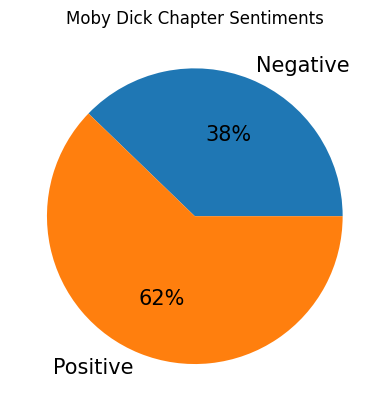

In [20]:
sentiment_dict.pop('Neutral')
plt.pie(x = sentiment_dict.values(), labels = sentiment_dict.keys(), autopct='%1.f%%', textprops={'fontsize': 15})
plt.title('Moby Dick Chapter Sentiments')

## Conclusion

The analysis of Moby Dick has resulted in an understanding that it is comprised of 135 chapters, of which 62% are positive and 38% are negative. 'Whale' is by far the most commonly occuring semantically-significant word in the book, appearing in 1,399 sentences.

Future enhancements could include examining the genre or category of the book, analyzing the emotional content of the book, or comparing this book to other books.